# DBSCAN
- 데이터 밀도 기반의 클러스터링 알고리즘
- 데이터 고밀도 지역을 하나의 군집으로 생성하고, 저밀도 지역은 노이즈(이상치)로 판단

- KMeans와는 다르게 군집 개수를 지정할 필요 없음
- 비선형 구조의 데이터에서도 군집 형성 가능 (원형, 나선형 구조 데이터의 패턴 분석 가능)
- 노이즈를 판단 -> 이상치에 대해 자동 감지
- 일반적으로 스케일링(Standard, MinMax) 사용

- **매개변수**
    - <span style="color:#ffd33d">**eps**</span>
        </br>: 두 개의 샘플이 같은 군집으로 간주되기 위한 최대 거리(반경)
        - 엡실론
        - 기본값: 0.5
            - 스케일링된 데이터 - eps값은 최대 2 정도
            - 스케일링되지 않은 데이터 - eps값은 피쳐 안의 데이터의 범위에 따라 변함
    - <span style="color:#ffd33d">**min_sample**</span>
        </br>: 핵심점(core point)으로 판단하기 위한(즉, 하나의 군집으로 인정하기 위한) 최소 샘플 수
        - 기본값: 5
    - <span style="color:#ffd33d">**metric**</span>
        </br>: 거리 계산 방식
        - 기본값: 'euclidean'
    - <span style="color:#ffd33d">**metric_params**</span>
        </br>: 거리 계산 시 추가 인자 설정
        - 기본값: None
    - <span style="color:#ffd33d">**algorithm**</span>
        </br>: 이웃 탐색 알고리즘
        - 기본값: auto
            - auto : 데이터 특성에 따라 알고리즘 자동 선택
            - 'ball_tree' : 고차원 데이터에서 효율적인 거리 탐색 (공간 분할 기반)
            - 'kd_tree' : 저차원(20차원 이하) 데이터에서 매우 빠른 성능
            - 'brute' : 모든 점 간의 거리를 계산 - 우수한 성능, 느린 속도 - 데이터의 개수가 적은(5000개 미만) 경우 사용
    - <span style="color:#ffd33d">**leaf_size**</span>
        </br>: Tree 알고리즘을 사용하는 경우에 리프의 크기를 지정 (성능 조절)
        - 기본값: 30

- **속성**
    - <span style="color:#ffd33d">**core_sample_indices_**</span>
        </br>: 핵심점의 인덱스 목록
    - <span style="color:#ffd33d">**components_**</span>
        </br>: 핵심점 좌표 배열
    - <span style="color:#ffd33d">**labels_**</span>
        </br>: 각 데이터의 군집의 라벨
        - 노이즈는 -1로 표시

- **메소드**
    - <span style="color:#ffd33d">**fit( )**</span>
        </br>: 모델에 데이터를 학습
    - <span style="color:#ffd33d">**predict( )**</span>
        </br>: 학습된 모델에서 데이터를 예측(군집의 라벨을 반환)

- 동작 원리
    1. 핵심점 생성 (각 점에 대해서 이웃한 점의 개수를 계산)
    2. 경계점 생성 (핵심점 근처에 존재하는 핵심이 아닌 점)
    3. 노이즈점 생성 (어떠한 군집에도 속하지 않은 데이터)
    4. 핵심점에서 시작해 이웃을 계속 측정하여 확장하면서 군집 생성

- 파라미터 튜닝 팁
    - 너무 많은 노이즈가 생성되었다면
        - eps 증가 또는 min_samples 감소
        </br> = 거리 증가 또는 한 거리 안의 최소 데이터 수 감소
        </br><span style="color:#808080">(그렇다고 eps를 너무 증가시키면 하나의 군집이 너무 커짐)
    - 클러스터(군집)이 너무 뭉쳐있다면
        - eps 감소
    - 데이터가 너무 고차원이라면
        - 차원 축소를 통해 고차원 데이터를 저차원 데이터로 변환 (PCA<span style="color:#808080">(선형)</span>, t-SNE<span style="color:#808080">(비선형)</span>)
    - 속도가 너무 느리다면
        - algorithm 을 kd_tree 로 변경 또는 n_jobs 를 -1 로 변경 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, \
    davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

In [2]:
# 데이터셋 로드 
df = pd.read_csv("../data/bodyPerformance.csv")

In [3]:
# object형 컬럼의 데이터들을 라벨인코더를 이용하여 수치형 데이터로 변환 
obj_cols =  df.select_dtypes('object').columns.tolist()

for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].values)

In [4]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


In [5]:

# 독립, 종속 데이터 변환 
X = df.drop('class', axis=1).values
Y = df['class'].values
# 독립 데이터는 스케일링 
X_std = StandardScaler().fit_transform(X)

In [6]:
# K번째(10) 최근접 이웃의 거리 계산 
nbrs = NearestNeighbors(n_neighbors=10).fit(X_std)
distances, _ = nbrs.kneighbors(X_std)

distances[:, -1]

array([0.98773763, 1.09658759, 1.16466538, ..., 1.29056459, 1.61649612,
       1.29657021], shape=(13393,))

In [7]:
# 각각의 데이터에서 10번째 이웃의 거리만 추출 
kth_list = np.sort(distances[:, -1])

# eps -> 꺽이는 지점
diffs = np.diff(kth_list)
eps_ = np.where(diffs > 0.05)[0]
eps_

array([13357, 13370, 13371, 13374, 13376, 13378, 13380, 13382, 13383,
       13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391])

In [ ]:
print( "급변하는 인덱스의 값 : ", eps_)
print( "대략적인 eps의 최적의 값 : ", round( kth_list[ eps_[0] ] ) )

급변하는 인덱스의 값 :  [13357 13370 13371 13374 13376 13378 13380 13382 13383 13384 13385 13386
 13387 13388 13389 13390 13391]
대략적인 eps의 최적의 값 :  3


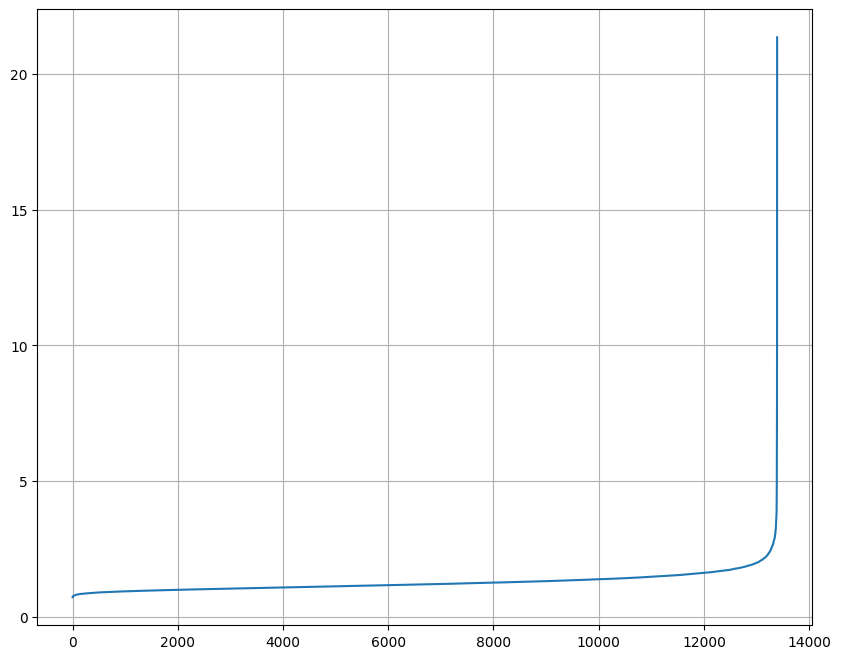

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(kth_list)
plt.grid(True)
plt.show()

In [10]:
eps = 1.7
min_samples = 10
# 모델 생성
db = DBSCAN(
    eps = eps, 
    min_samples= min_samples, 
    n_jobs= -1
)
# 모델에 데이터 학습 및 예측
labels = db.fit_predict(X_std)

In [11]:
# 라벨의 구성 -> 군집이 여러개인 경우 0, 1, 2, ... / 노이즈 -1
# 라벨의 개수를 확인 
set(labels)

{np.int64(-1), np.int64(0), np.int64(1)}

In [12]:
# 노이즈의 개수 -> labels에서 -1의 개수 -> 
n_noise = np.sum(labels == -1)


In [13]:
# 검증 지표 계산 
# 노이즈 제외하고 계산 
mask = labels != -1
sil = silhouette_score(X_std[mask], labels[mask])
ch = calinski_harabasz_score(X_std[mask], labels[mask])
dbi = davies_bouldin_score(X_std[mask], labels[mask])
# 실제 라벨과 검증 지표(Y에는 노이즈도 포함) -> 라벨의 개수가 다르기때문에 값은 낮게 측정 
ari = adjusted_rand_score(Y, labels)
nmi = normalized_mutual_info_score(Y, labels)
print('silhoutte : ', round(sil, 4))
print('calinski_harabasz : ', round(ch, 4))
print('davies_bouldin : ', round(dbi, 4))
print('ARI : ', round(ari, 4))
print('NMI : ', round(nmi, 4))

silhoutte :  0.3466
calinski_harabasz :  7795.7073
davies_bouldin :  1.2023
ARI :  0.005
NMI :  0.0182


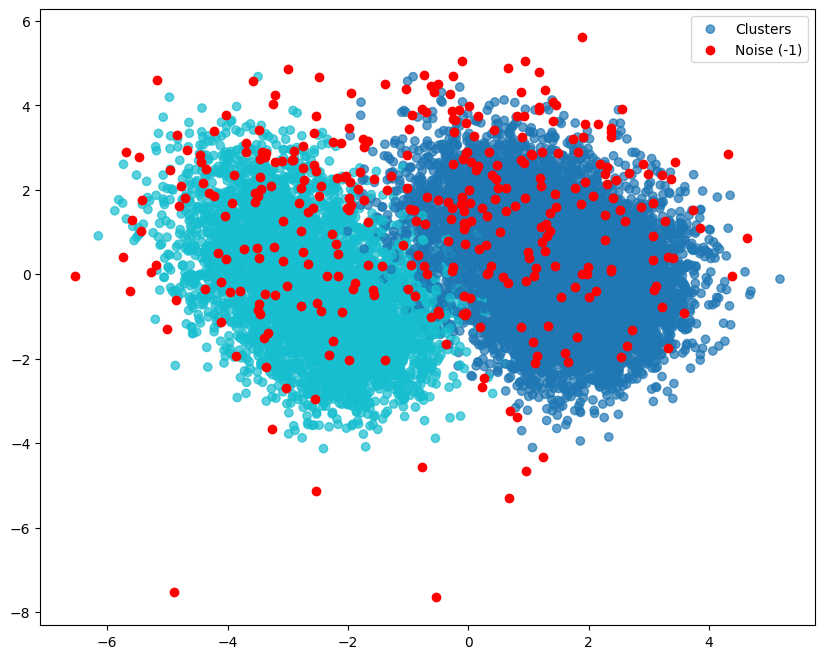

In [14]:
# PCA을 이용하여 2차원으로 차원 축소 하고 그래프 시각화 

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(10, 8))

# 노이즈 / 비노이즈 부분을 다르게 표시 
non_noise = labels != -1
# true_noise = labels == -1
# 비노이즈의 산점도 그래프
plt.scatter( X_pca[non_noise, 0], X_pca[non_noise, 1], c = labels[non_noise], 
            cmap = 'tab10', label='Clusters', alpha=0.7)
# 노이즈의 산점도 그래프 -> non_noise 불형태의 1차원 데이터에서 부정 연산자 사용
plt.scatter( X_pca[~non_noise, 0], X_pca[~non_noise, 1], c='red', label='Noise (-1)' )

plt.legend()

plt.show()

In [15]:
# 같은 데이터셋을 이용하여 eps 값은 1.3
# min_samples 의 값 10
# 으로 DBSCAN을 이용하여 군집화 하고 실루엣 검증 지표와 PCA를 이용한 2차원 그래프를 생성 

eps2 = 1.3
min_samples2 = 10

db2 = DBSCAN(
    eps = eps2, 
    min_samples= min_samples2, 
    n_jobs=-1
)

In [16]:
labels2 = db2.fit_predict(X_std)

In [17]:
n_clusters2 = len(set(labels2)) - ( 1 if -1 in labels2 else 0 )
n_noise = np.sum(labels2 == -1)
print("노이즈의 개수는 :", n_noise)

노이즈의 개수는 : 1943


In [18]:
mask2 = labels2 != -1

sil2 = silhouette_score(X_std[mask2], labels2[mask2])

print('silhouette : ', round(sil, 4))
print('silhouette2 : ', round(sil2, 4))

silhouette :  0.3466
silhouette2 :  0.3701


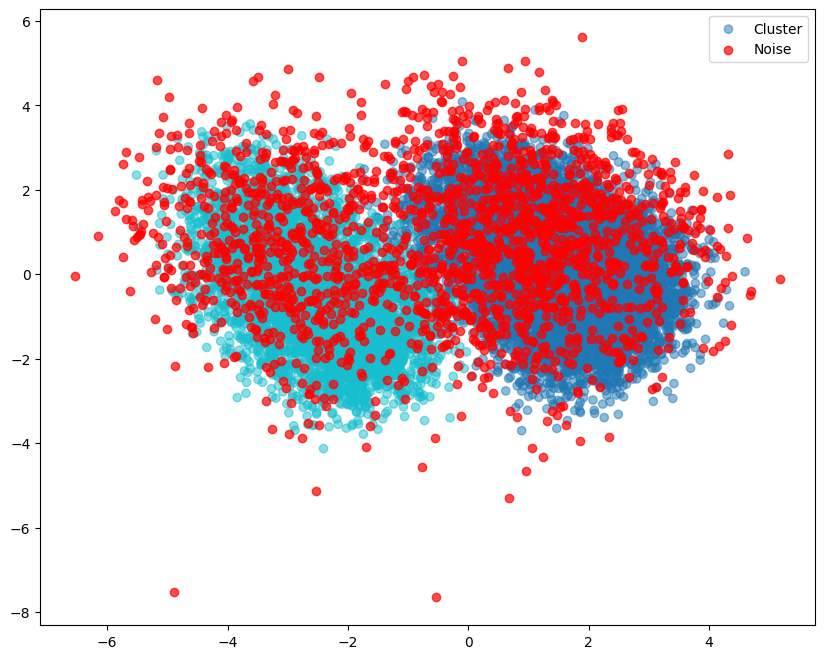

In [19]:
non_noise2 = labels2 != -1

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[non_noise2 , 0], X_pca[non_noise2, 1], c = labels2[non_noise2], 
            cmap = 'tab10', label = 'Cluster', alpha=0.5)
plt.scatter(X_pca[~non_noise2, 0], X_pca[~non_noise2, 1], c = 'red', label='Noise', 
            alpha=0.7)

plt.legend()
plt.show()